# RideAustin Data Analytics Overview

This Jupyter Notebook was used to conduct the analysis described in the [Wenzel et al. (2019)](https://doi.org/10.1016/j.trd.2019.03.005).


Step 1: Import all packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, viridis, inferno

ModuleNotFoundError: No module named 'datashader'

Step 2: Set up the great circle distance function here to calculate distances between origins and destinations of pick-ups and drop-offs respectively

In [17]:
def dist_mi(lat1, lon1, lat2, lon2):
    radius = 6371.0/1.609344 # mi
    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2.0) * np.sin(dlat/2.0) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2.0) * np.sin(dlon/2.0)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))
    d = radius * c
    return d

dist_corr = 1.419 #network distance
avg_speed = 20 #mph

Step 3: Load data, compute trips VMT and travel times

In [3]:
#data loading and time conversions
rides_A = pd.read_csv('Rides_DataA.csv', usecols = ['RIDE_ID','started_on','completed_on','distance_travelled',
                                                         'start_location_lat', 'start_location_long', 
                                                         'end_location_lat', 'end_location_long','rider_id'])
rides_B = pd.read_csv('Rides_DataB.csv', usecols = ['RIDE_ID','total_fare','driver_id', 'dispatched_on','make', 'model','year'])
rides = rides_A.merge(rides_B, on='RIDE_ID')
rides.drop_duplicates(subset=['started_on','completed_on','start_location_lat','start_location_long','end_location_lat', 'end_location_long'], inplace=True)
rides.rename(columns={'RIDE_ID': 'ride_id'}, inplace=True)
rides.loc[:,'started_on'] = pd.to_datetime(rides.started_on, utc=True).dt.tz_convert('US/Central').dt.tz_localize(None)
rides.loc[:,'completed_on'] = pd.to_datetime(rides.completed_on, utc=True).dt.tz_convert('US/Central').dt.tz_localize(None)
rides.loc[:,'distance_travelled'] = rides.distance_travelled.divide(1609.34)

#compute times and distance
rides = rides.assign(distance_computed = dist_corr*dist_mi(rides.start_location_lat, rides.start_location_long,rides.end_location_lat, rides.end_location_long))
rides.loc[:,'make'] = rides.make.apply(lambda x: x[2:-1]).str.lower()#.str.replace("'", "")
rides.loc[:,'model'] = rides.model.apply(lambda x: x[2:-1]).str.lower()#.str.replace("'", "")
rides.loc[:,'year'] = rides.year.apply(lambda x: x[2:-1]).astype(int)#.replace("'", "")
rides.loc[rides.year==2104, 'year'] = 2014
rides.loc[rides.make=='tessla', 'make'] = 'tesla'
rides = rides.assign(hour = rides.completed_on.dt.hour)
rides = rides.assign(dow = rides.completed_on.dt.dayofweek)
rides = rides.assign(trip_duration = (rides.completed_on - rides.started_on) / pd.Timedelta('60 minutes'))
rides = rides.assign(avg_speed = rides.distance_travelled.divide(rides.trip_duration))

Step 4: Review data and conduct cleaning & filtering

In [22]:
rides = rides.loc[(rides.ride_id!=1476963) & (rides.ride_id!=45376)& (rides.ride_id!=197073)]
rides = rides.loc[(rides.distance_travelled>0.05)&(rides.distance_travelled<400)]
rides = rides.loc[(rides.end_location_lat!=0)|(rides.end_location_long!=0)]
rides = rides.loc[rides.start_location_lat<36]
rides = rides.loc[rides.completed_on >= rides.started_on + pd.Timedelta('10 seconds')]
rides = rides.loc[rides.avg_speed<80]
rides.sort_values(by=['driver_id', 'completed_on'], inplace = True)
rides.reset_index(drop=True, inplace=True)

Step 5: Identify TNC drivers shifts and segment these

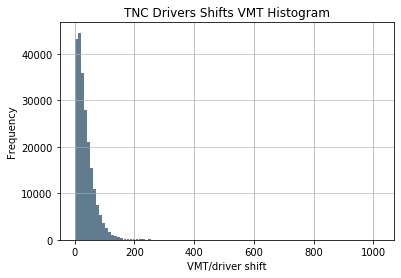

In [32]:
#calculate dwell time in between drivers rides
dwell_time = rides.started_on.shift(-1) - rides.completed_on
dwell_time.loc[rides.driver_id.shift(-1) != rides.driver_id] = pd.Timedelta('0 hours') #np.nan 

#based on dwell_time outcomes assign a shift_id
rides = rides.assign(shift_id = 0)
rides.loc[(dwell_time.shift(1)>pd.Timedelta('8 hours')) | (dwell_time.shift(1)==pd.Timedelta('0 hours')), 'shift_id'] = 1 #(pd.isnull(dwell_time.shift(1)))
rides.loc[:,'shift_id'] = rides.shift_id.cumsum()
shifts = rides.groupby('shift_id')

#calculate shifts VMT
svmt = shifts.distance_travelled.sum()
shift_length = shifts.completed_on.last()-shifts.started_on.first()
cvmt = shifts.distance_travelled.cumsum()

svmt.plot.hist(grid=True, bins=100, rwidth=0.9, color='#607c8e')
plt.title('TNC Drivers Shifts VMT Histogram')
plt.xlabel('VMT/Driver Shift')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

Step 6: Compute dwell time and synthesize dead-heading

In [6]:
dwell_time = rides.started_on.shift(-1) - rides.completed_on

#calculation of deadheading distance in between trips (using network distance assumption)
deadhead_dist = dist_corr * dist_mi(rides.end_location_lat, rides.end_location_long, rides.start_location_lat.shift(-1), rides.start_location_long.shift(-1))
deadhead_dist.loc[rides.shift_id.shift(-1) != rides.shift_id] = np.nan
dwell_time.loc[rides.shift_id.shift(-1) != rides.shift_id] = pd.Timedelta('0 hours')

deadhead_duration = pd.Timedelta('1 hours')*deadhead_dist/avg_speed
deadhead_dwell = dwell_time - deadhead_duration
deadhead_duration.loc[deadhead_dwell<pd.Timedelta('0 hours')] = dwell_time.loc[deadhead_dwell<pd.Timedelta('0 hours')]
deadhead_dwell.loc[deadhead_dwell<pd.Timedelta('0 hours')] = pd.Timedelta('0 hours')
deadhead = pd.DataFrame({'shift_id':rides.shift_id, 'driver_id':rides.driver_id, 'distance_travelled':deadhead_dist, 'started_on': rides.completed_on+deadhead_dwell, 
                         'completed_on': rides.started_on.shift(-1), 'dwell_time': pd.Timedelta('0 hours'),'dest_type':3,
                         'end_location_lat': rides.start_location_lat.shift(-1), 'end_location_long':rides.start_location_long.shift(-1),
                         'start_location_lat': rides.end_location_lat, 'start_location_long':rides.end_location_long})
deadhead.dropna(inplace=True)
rides = rides.assign(dwell_time = deadhead_dwell)

Step 7: Synthesize driver shifts commuting

In [7]:
#get home location of the driver
home_lat = shifts.first().groupby('driver_id').start_location_lat.median().rename('home_lat')
home_long = shifts.first().groupby('driver_id').start_location_long.median().rename('home_long')
home = pd.concat([home_lat,home_long], axis = 1)
rides = rides.merge(home, left_on = 'driver_id', right_index=True)
shifts = rides.groupby('shift_id')

#first and last trip of the day - calculate commute's distance and location
first_commute_dist = dist_corr*dist_mi(shifts.first().home_lat, shifts.first().home_long,shifts.first().start_location_lat, shifts.first().start_location_long)
first_commute_dur = pd.Timedelta('1 hours')*first_commute_dist/avg_speed
first_commute = pd.DataFrame({'shift_id':shifts.shift_id.first(), 'driver_id':shifts.first().driver_id, 'distance_travelled':first_commute_dist, 'started_on': shifts.first().started_on-first_commute_dur, 
                         'completed_on': shifts.first().started_on, 'dwell_time': pd.Timedelta('0 hours'),
                         'end_location_lat': shifts.first().start_location_lat, 'end_location_long':shifts.first().start_location_long,
                         'start_location_lat': shifts.first().home_lat, 'start_location_long':shifts.first().home_long})
    
last_commute_dist = dist_corr*dist_mi(shifts.last().end_location_lat, shifts.last().end_location_long,shifts.last().home_lat, shifts.last().home_long)
last_commute_dur = pd.Timedelta('1 hours')*last_commute_dist/avg_speed
last_commute = pd.DataFrame({'shift_id':shifts.shift_id.first(), 'driver_id':shifts.first().driver_id, 'distance_travelled':last_commute_dist, 'started_on': shifts.last().completed_on, 
                           'completed_on': shifts.last().completed_on+last_commute_dur,                        
                         'dest_type':1,'start_location_lat': shifts.last().end_location_lat, 'start_location_long':shifts.last().end_location_long,
                         'end_location_lat': shifts.last().home_lat, 'end_location_long':shifts.last().home_long})


Step 8: Add commutes + dead-heading to trip dataframe

In [30]:
all_trips = pd.concat([rides,deadhead,first_commute,last_commute], axis=0)
#all_trips = all_trips.loc[-all_trips.shift_id.isin(all_trips.loc[all_trips.dwell_time<pd.Timedelta('0 days'),'shift_id'])]
all_trips.sort_values(by=['shift_id', 'completed_on'], inplace = True)
all_trips.reset_index(inplace=True)
shifts = all_trips.groupby('shift_id')
svmt = shifts.distance_travelled.sum()
shift_driver = shifts.driver_id.first()
shift_length = shifts.completed_on.last()-shifts.started_on.first()
cvmt = shifts.distance_travelled.cumsum()
svmt = shifts.distance_travelled.sum()
max_driver_svmt = all_trips.groupby(['driver_id','shift_id']).distance_travelled.sum().groupby('driver_id').max()
max_shift_dwell = shifts.dwell_time.max()
shifts = pd.concat([shift_length.rename('shift_length'), shift_driver], axis=1)
hours_worked = shifts.groupby('driver_id').shift_length.sum()/pd.Timedelta('1 hours')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Ridesourcing Efficiency Ratio
Calculate "Efficiency ratio" for all trips (actual productive ridesourcing travel with passenger divided by total VMT conducted - including deadheading and shifts commute)

In [31]:
rides.distance_travelled.sum()/all_trips.distance_travelled.sum()

0.5140198703612706

Step 9: Calculate driver statistics

In [11]:
drivers = rides.groupby('driver_id')
cars = drivers.first().groupby(['make', 'model','year']).size()
cars = cars.rename('cars').reset_index()
driver_id_lst = drivers.driver_id.first()
earnings = drivers.total_fare.sum().rename('earnings')
num_trips = drivers.size().rename('num_trips')
sample_duration = ((drivers.completed_on.last()-drivers.started_on.first()).dt.ceil('d')/pd.Timedelta('1 days'))
sample_vmt = drivers.distance_travelled.sum().rename('sample_vmt')
annualized_vmt = 365.25*sample_vmt/sample_duration # factor 2 is for empty miles + passenger miles
drivershifts = rides.groupby(['driver_id', 'shift_id'])
num_shifts = drivershifts.size().groupby('driver_id').size().rename('num_shifts')
trips_per_shift = num_trips/num_shifts
shifts_per_week = 7*num_shifts/sample_duration
hours_per_week = 7*hours_worked/sample_duration
earnings_per_week = 7*earnings/sample_duration
earnings_per_hour = earnings/hours_worked
drivers = pd.concat([driver_id_lst,hours_per_week.rename('hours_per_week'), sample_duration.rename('sample_duration'), sample_vmt, annualized_vmt.rename('annualized_vmt'), trips_per_shift.rename('trips_per_shift'), num_shifts, num_trips, shifts_per_week.rename('shifts_per_week')], axis=1)

Step 10: Calculate the share of trips conducted by regular drivers/ all TNC drivers

In [12]:
regular_drivers = drivers.loc[(drivers.sample_duration>14)&(drivers.hours_per_week>12), 'driver_id']
regular_trips = all_trips.loc[all_trips.driver_id.isin(regular_drivers)]
len(regular_trips.index)/float(len(all_trips.index))

0.8042387275852325

Step 11: Match data with land use characteristics

In [13]:
dest_land_use = pd.read_csv('dest_land_use.csv', sep =';')
orig_land_use = pd.read_csv('orig_land_use.csv', sep =';')
land_use = rides.merge(orig_land_use, on ='ride_id')
land_use = land_use.merge(dest_land_use, on ='ride_id', suffixes = ['_o','_d'])
land_use = land_use.assign(from_home = 0)
land_use = land_use.assign(from_work = 0)
#land_use = land_use.assign(from_airport = 0)
land_use = land_use.assign(to_home = 0)
land_use = land_use.assign(to_work = 0)
#land_use = land_use.assign(to_airport = 0)
land_use.loc[land_use.land_use_o < 300, 'from_home'] = 1
land_use.loc[land_use.land_use_o == 400, 'from_work'] = 1
#land_use.loc[land_use.land_use_x == 830, 'from_airport'] = 1
land_use.loc[land_use.land_use_d < 300, 'to_home'] = 1
land_use.loc[land_use.land_use_d == 400, 'to_work'] = 1
#land_use.loc[land_use.land_use_y == 830, 'to_airport'] = 1

Step 12: Create a heatmap of non-residential destinations

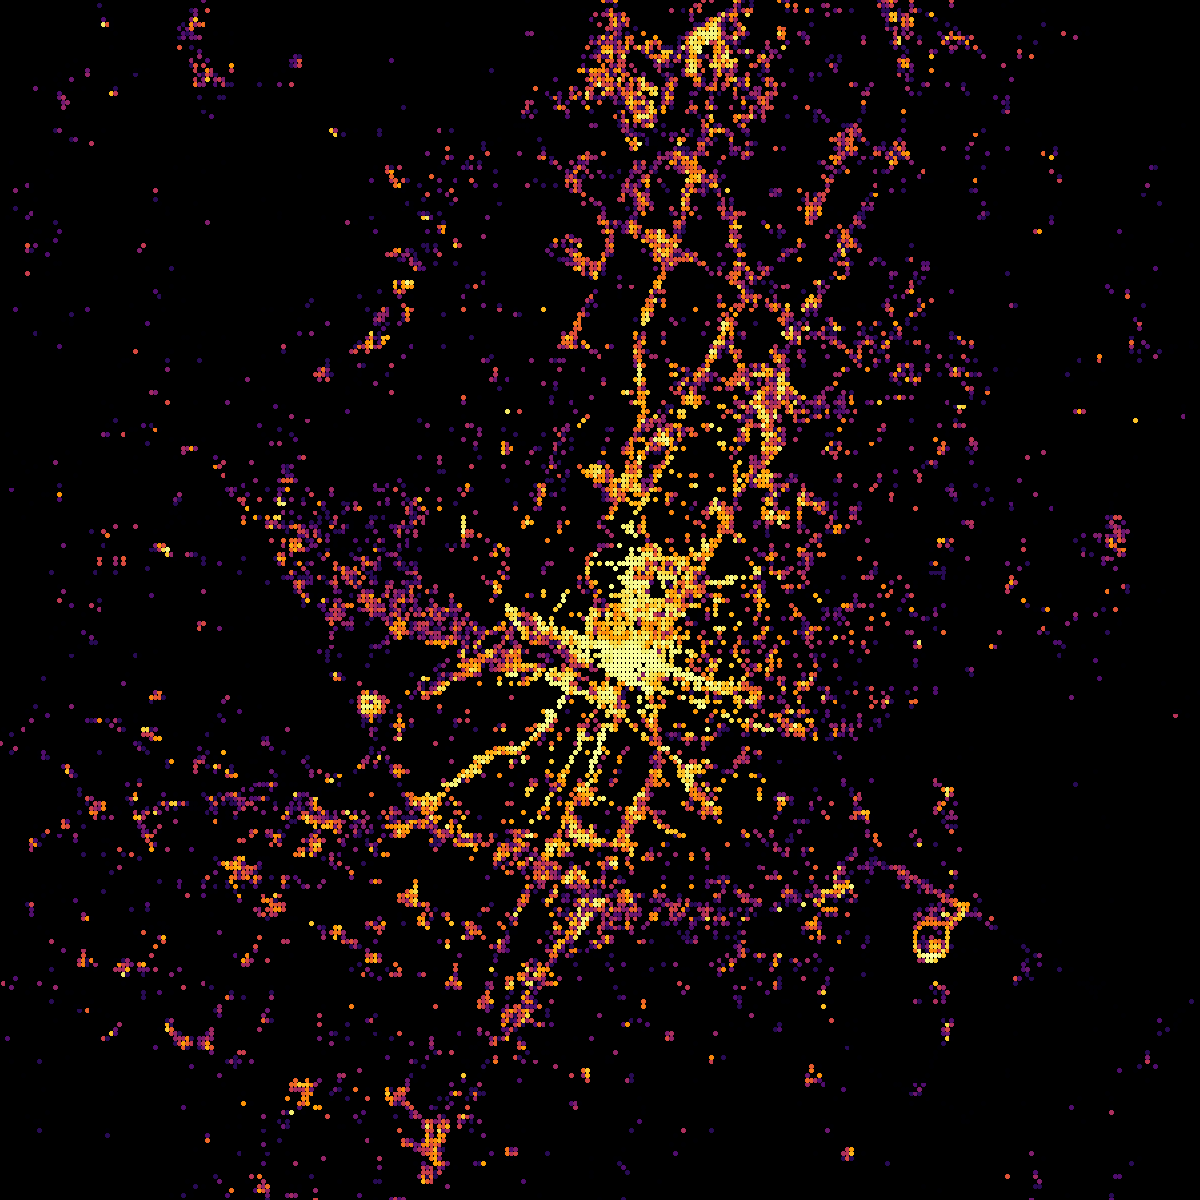

In [30]:
cvs = ds.Canvas(1200, 1200, x_range=( -97.90,  -97.60), y_range=(30.15, 30.41))
agg = cvs.points(land_use.loc[land_use.to_home==0], 'end_location_long', 'end_location_lat')
img = tf.shade(agg, cmap = inferno, how='eq_hist')
tf.set_background(tf.dynspread(img, threshold=0.56, max_px=4, shape='circle'), "black")

Step 12: Create a heatmap of residential destinations

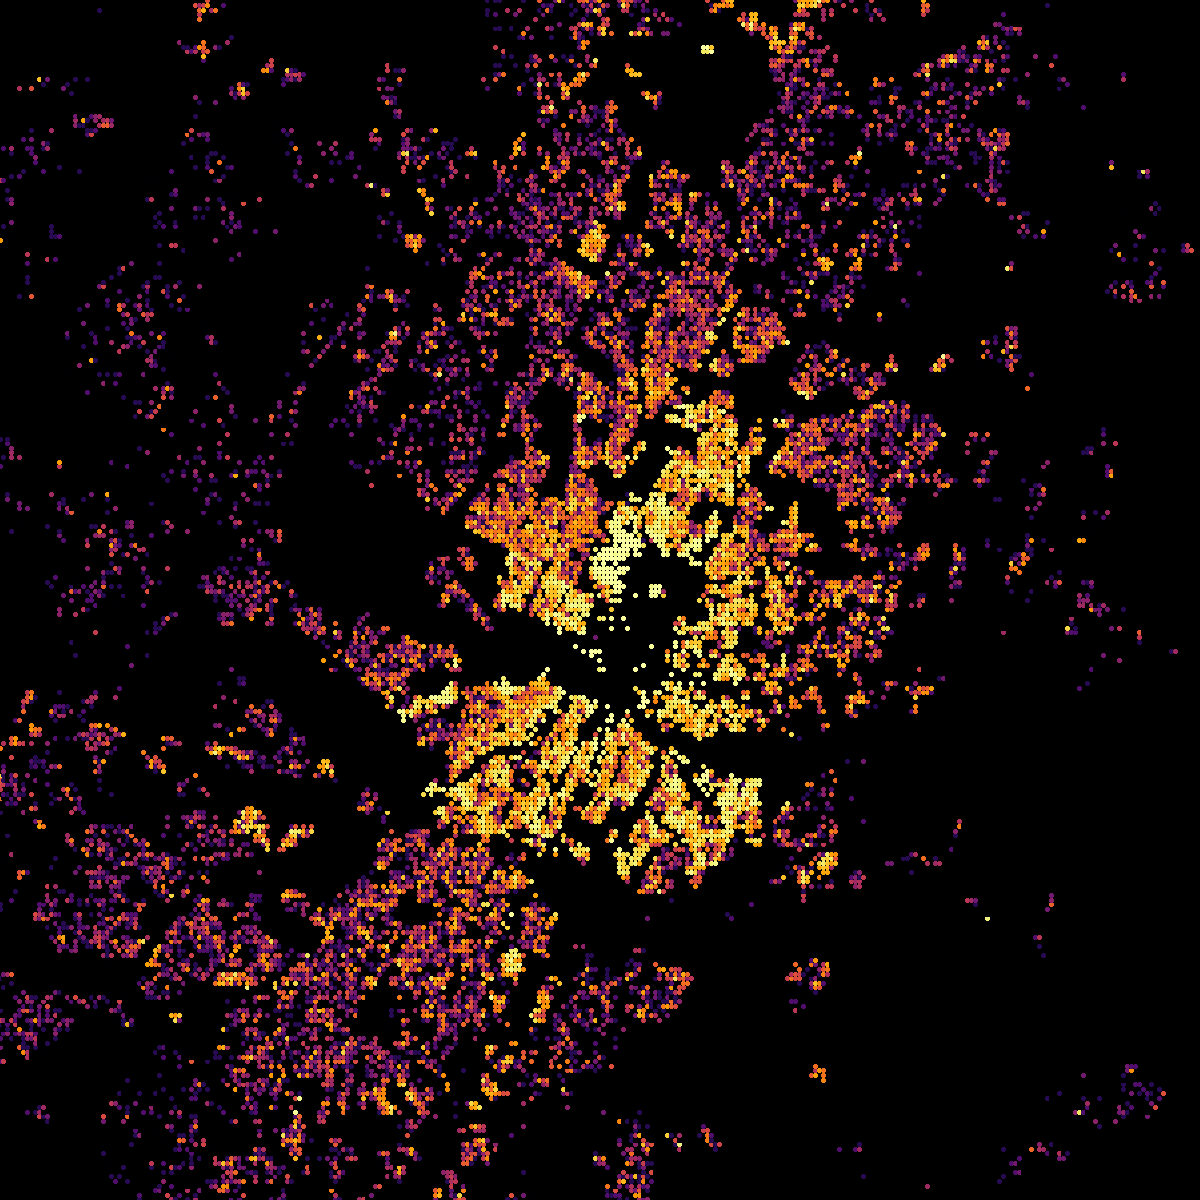

In [31]:
cvs = ds.Canvas(1200, 1200, x_range=( -97.90,  -97.60), y_range=(30.15, 30.41))
agg = cvs.points(land_use.loc[land_use.to_home==1], 'end_location_long', 'end_location_lat')
img = tf.shade(agg, cmap = inferno, how='eq_hist')
tf.set_background(tf.dynspread(img, threshold=0.56, max_px=4, shape='circle'), "black")